In [1]:
import pickle
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

In [2]:
data_file_path = "../data/20250512/processed/ishii_merged.pkl"

In [3]:
# pickleのEEGデータを読み込む
with open(data_file_path, 'rb') as f:
    data = pickle.load(f)

epochs_list = data['epochs_data']  # エポックデータ
labels = data['labels']  # ラベル
# drop_indices = data['drop_indices']  # 除外されたエポックのインデックス
fs = 500

In [4]:
# labelsが9999のものを除外する
valid_indices = np.where(labels != 9999)[0]
epochs_list = epochs_list[valid_indices]
labels = labels[valid_indices]

In [5]:
epochs_list.shape

(80, 31, 1501)

In [6]:
labels.shape

(80,)

In [7]:
# 1チャンネルのデータをDFTしてバンドパスパワーを計算
def calc_spectrum(data, band_count, fs):
    n = len(data)
    freq = np.fft.fftfreq(n, 1/fs)
    spectrum = np.fft.fft(data)
    # 1Hz-40Hzまでの4Hzごとのバンドパスパワーを計算
    band_lower = 0
    band_upper = 40
    band_powers = [None] * band_count
    for i in range(band_count):
        band = band_lower+i*(band_upper-band_lower)/band_count, band_lower+(i+1)*(band_upper-band_lower)/band_count
        band_power = np.sum(np.abs(spectrum[(freq >= band[0]) & (freq < band[1])])**2)
        band_powers[i] = band_power
    
    # band_powersの中にNoneがないことをassert
    # assert all([v is not None for v in band_powers]), "Some band powers are None"
    assert all(band_powers), "Some band powers are None"
    return band_powers

In [8]:
e0 = epochs_list[0, :, :]
e0c0 = epochs_list[0, 0, :]
e0c0

array([-3.09768487e-06,  3.63364521e-07,  2.80526288e-06, ...,
        7.68275722e-07,  4.69808578e-06,  7.49846645e-06], shape=(1501,))

In [9]:
calc_spectrum(e0c0, 10, fs)

[np.float64(1.6344817694369637e-05),
 np.float64(6.191345721037872e-06),
 np.float64(5.352101709351605e-06),
 np.float64(7.969783152084606e-06),
 np.float64(8.109983954899702e-06),
 np.float64(1.4948249255720512e-05),
 np.float64(4.294444496407311e-06),
 np.float64(7.07153784062095e-06),
 np.float64(7.285600842563042e-06),
 np.float64(6.614251397298713e-06)]

In [10]:
# epochs_list[0]の各チャンネルのDFTを計算
def calc_spectrum_all_channels(epoch, band_count, fs):
    n_channels = epoch.shape[0]
    band_powers = np.zeros((n_channels, band_count))
    for i in range(n_channels):
        band_powers[i] = calc_spectrum(epoch[i, :], band_count, fs)
    return band_powers

In [11]:
calc_spectrum_all_channels(e0, 20, fs)

array([[1.37952606e-05, 2.54955707e-06, 3.50636094e-06, 2.68498478e-06,
        3.08153320e-06, 2.27056851e-06, 2.87801547e-06, 5.09176769e-06,
        3.51052396e-06, 4.59946000e-06, 5.33856877e-06, 9.60968048e-06,
        2.29316735e-06, 2.00127715e-06, 4.49137931e-06, 2.58015853e-06,
        2.75834059e-06, 4.52726025e-06, 3.64984301e-06, 2.96440839e-06],
       [1.43117488e-05, 3.66784429e-06, 4.76457570e-06, 2.81048299e-06,
        3.06596400e-06, 1.96706070e-06, 2.54530677e-06, 4.95626101e-06,
        3.90254520e-06, 4.27690761e-06, 5.20790763e-06, 9.38355749e-06,
        2.56312294e-06, 2.17900164e-06, 4.70209766e-06, 2.89495971e-06,
        3.12531883e-06, 3.67532470e-06, 4.20940234e-06, 2.88414173e-06],
       [1.53352081e-05, 3.32844648e-06, 4.40700462e-06, 2.52888731e-06,
        3.35223391e-06, 1.83980726e-06, 2.43904099e-06, 5.70119438e-06,
        3.99552581e-06, 3.64218926e-06, 5.97914485e-06, 9.92587735e-06,
        2.47647005e-06, 2.12712974e-06, 4.25789010e-06, 3.1109

In [12]:
band_count = 20
all_epochs_band_powers = np.zeros((epochs_list.shape[0], epochs_list.shape[1], band_count))
for i in range(epochs_list.shape[0]):
    for j in range(epochs_list.shape[1]):
        all_epochs_band_powers[i] = calc_spectrum_all_channels(epochs_list[i], band_count, fs)

In [13]:
all_epochs_band_powers

array([[[1.37952606e-05, 2.54955707e-06, 3.50636094e-06, ...,
         4.52726025e-06, 3.64984301e-06, 2.96440839e-06],
        [1.43117488e-05, 3.66784429e-06, 4.76457570e-06, ...,
         3.67532470e-06, 4.20940234e-06, 2.88414173e-06],
        [1.53352081e-05, 3.32844648e-06, 4.40700462e-06, ...,
         3.18264364e-06, 4.44488430e-06, 2.79569646e-06],
        ...,
        [2.64813016e-05, 7.98193287e-06, 7.00108816e-06, ...,
         1.15753778e-05, 6.23742892e-06, 6.68422812e-06],
        [4.24344250e-05, 6.84888930e-06, 1.02194652e-05, ...,
         4.88348976e-06, 6.38844103e-06, 3.14343212e-06],
        [1.89683809e-05, 5.10572174e-06, 5.69915085e-06, ...,
         5.40724149e-06, 3.67787503e-06, 3.89437591e-06]],

       [[3.34190778e-06, 2.69820764e-06, 9.82066700e-07, ...,
         5.93345656e-06, 2.64785614e-06, 4.22627644e-06],
        [9.22456365e-06, 3.48161228e-06, 2.06882546e-06, ...,
         5.71900334e-06, 2.55551355e-06, 4.41169790e-06],
        [5.79493939e-06, 

In [14]:
# 特徴量を2次元配列に変換（サンプル数×特徴量）
# 31*20=620の特徴量を持つ40個のデータに変換
X = all_epochs_band_powers.reshape(all_epochs_band_powers.shape[0], -1)
print(f"特徴量のshape: {X.shape}")
print(f"ラベルのshape: {labels.shape}")

特徴量のshape: (80, 620)
ラベルのshape: (80,)


In [15]:
# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42, stratify=labels)

In [16]:
# 特徴量のスケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# SVMモデルの作成と学習
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)

# テストデータで予測
y_pred = svm.predict(X_test_scaled)

# 評価
print("分類レポート:")
print(classification_report(y_test, y_pred))# ラベルの分布を確認
unique_labels, counts = np.unique(labels, return_counts=True)
print("ラベルの分布:")
for label, count in zip(unique_labels, counts):
    print(f"ラベル {label}: {count}個")

分類レポート:
              precision    recall  f1-score   support

           1       0.45      0.56      0.50         9
           2       0.00      0.00      0.00         7
           3       0.33      0.50      0.40         8

    accuracy                           0.38        24
   macro avg       0.26      0.35      0.30        24
weighted avg       0.28      0.38      0.32        24

ラベルの分布:
ラベル 1: 28個
ラベル 2: 24個
ラベル 3: 28個


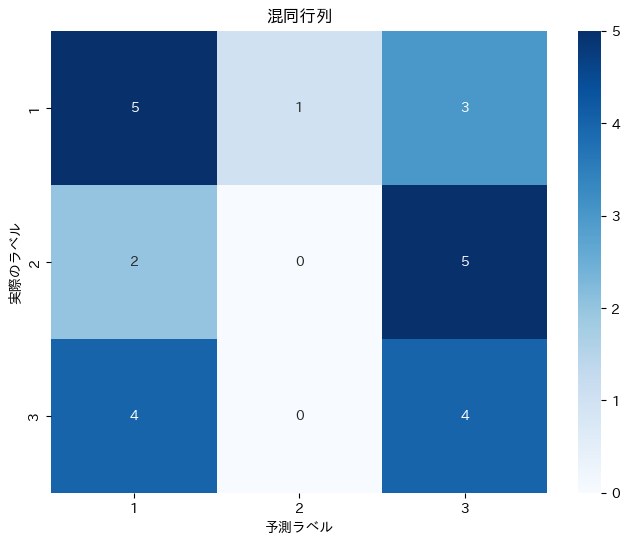

In [18]:
# 混同行列の表示
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=unique_labels, 
           yticklabels=unique_labels)
plt.xlabel('予測ラベル')
plt.ylabel('実際のラベル')
plt.title('混同行列')
plt.show()

クロスバリデーションスコア: [0.33333333 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.4        0.2        0.         0.2       ]
平均精度: 0.1967 ± 0.1016


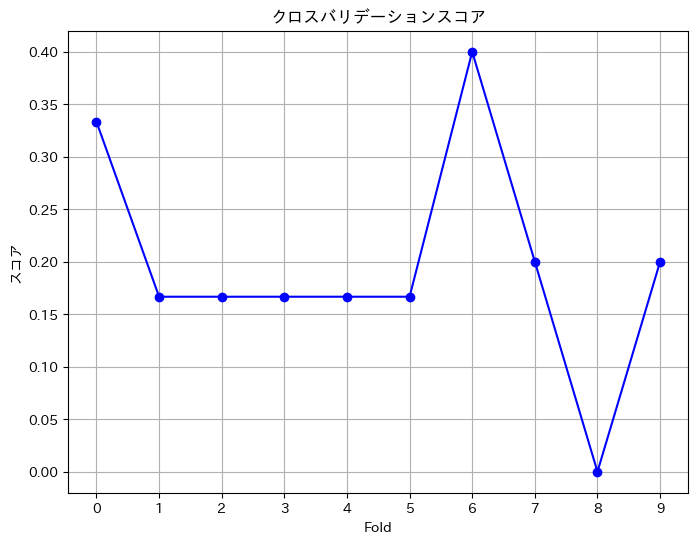

In [19]:
# クロスバリデーションで評価
cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=10)
print(f"クロスバリデーションスコア: {cv_scores}")
print(f"平均精度: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
# クロスバリデーションの結果をプロット
plt.figure(figsize=(8, 6))
plt.plot(cv_scores, marker='o', linestyle='-', color='b')
plt.title('クロスバリデーションスコア')
plt.xlabel('Fold')
plt.ylabel('スコア')
plt.xticks(range(len(cv_scores)))
plt.grid()
plt.show()

In [20]:
# ハイパーパラメータチューニング
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"最適パラメータ: {grid_search.best_params_}")
print(f"最高スコア: {grid_search.best_score_:.4f}")


最適パラメータ: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
最高スコア: 0.4033


最適モデルのクロスバリデーションスコア: [0.5        0.33333333 0.33333333 0.33333333 0.16666667 0.16666667
 0.4        0.6        0.6        0.6       ]
最適モデルの平均精度: 0.4033 ± 0.1588
最適モデルの分類レポート:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         7
           3       0.32      0.75      0.44         8

    accuracy                           0.25        24
   macro avg       0.11      0.25      0.15        24
weighted avg       0.11      0.25      0.15        24



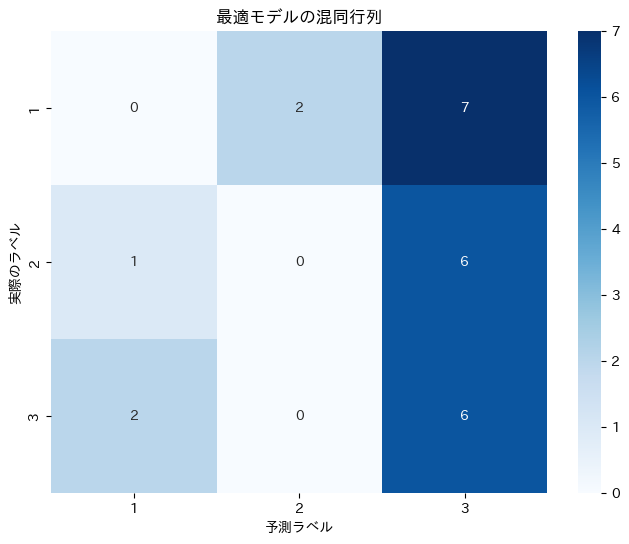

In [23]:
# 最適なモデルで評価
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)

# 最適なモデルのCVスコアを計算
best_cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=10)
print(f"最適モデルのクロスバリデーションスコア: {best_cv_scores}")
print(f"最適モデルの平均精度: {best_cv_scores.mean():.4f} ± {best_cv_scores.std():.4f}")

print("最適モデルの分類レポート:")
print(classification_report(y_test, y_pred_best))

# 混同行列の表示
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
           xticklabels=unique_labels, 
           yticklabels=unique_labels)
plt.xlabel('予測ラベル')
plt.ylabel('実際のラベル')
plt.title('最適モデルの混同行列')
plt.show()